# Writing Cloud Optimized Geotiffs (COGs) with Python

## Environment

The packages needed for this notebook can be installed with `conda` or `mamba`. Using the [`environment.yml` from this folder](./environment.yml) run:

```bash
conda env create -f environment.yml
```

or

```bash
mamba env create -f environment.yml
```

Finally, you may activate and select the kernel in the notebook (running in Jupyter)

```bash
conda activate coguide-cog
```

The notebook has been tested to work with the listed Conda environment.

## Setup

This tutorial will explore accessing a regular GeoTIFF (Non-COG), converting it to Cloud-Optimized GeoTIFF (COG) format with Python and validate the data inside the COG and Non-COG.

## About the Dataset

We will be using the [NASADEM Merged DEM Global 1 arc second V001](https://doi.org/10.5067/MEASURES/NASADEM/NASADEM_HGT.001) from the NASA EarthData. To access NASA EarthData into Jupyter Notebook, you can create an account by visiting [NASA's Earthdata Login page](https://urs.earthdata.nasa.gov/users/new). This will enable you to register for an account and retrieve the datasets used in the notebook.

We will use [earthaccess](https://github.com/nsidc/earthaccess) library to set up credentials to fetch data from NASA's EarthData catalog.

In [2]:
import earthaccess
import rasterio
from rasterio.plot import show
from rasterio.io import MemoryFile
from rasterio.shutil import copy
from rio_cogeo import cog_validate, cog_info
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
import os
import numpy

/opt/homebrew/anaconda3/envs/coguide-cog/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
earthaccess.login()

## Creating a Data Directory for this Tutorial

We are creating a data directory for downloading all the required files locally. 

In [5]:
# set data directory path
data_dir = './data'

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

## Downloading the Dataset from EarthData

We are using `search_data` method from the `earthaccess` module for searching the Granules from the selected collection.

In [6]:
# Search Granules
short_name = 'NASADEM_HGT'
version = '001'

dem_item_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    count=2
)

Granules found: 14520


In [7]:
# Download Data - Selecting the 2nd file from the `dem_item_results` list
nasa_dem_files = earthaccess.download(dem_item_results[1], data_dir)
nasa_dem_filename = f"{nasa_dem_files[0]}"
print(nasa_dem_filename)

 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 871.09it/s]


File NASADEM_HGT_n57e105.zip already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 11214.72it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]

data/NASADEM_HGT_n57e105.zip


## Loading the Downloaded file 

We will use `rasterio` to read the downloaded zip file. The `rasterio.open` uses GDAL’s [virtual filesystem interface](https://gdal.org/user/virtual_file_systems.html) to access local ZIP datasets. This requires prepending `zip` to the local zip file URI and adding the internal location to the dataset file after the `!` character. For more details, refer [here](https://rasterio.readthedocs.io/en/latest/topics/vsi.html). 

It is required to prepend `zip://` for accessing the HGT file using a relative path. However, if we want to use an absolute path, then `zip:///` should be preprended. Readers are encouraged to follow [GDAL virtual file systems read capabilities](https://gdal.org/user/virtual_file_systems.html#vsizip-zip-archives) for more details.

Additionally, we will be using `rasterio.open` in a `rasterio.Env` so as to define the `GDAL_DRIVER_NAME` for opening the `SRTM` files. GDAL has an in-built SRTMHGT [driver](https://gdal.org/drivers/raster/srtmhgt.html) for opening the SRTM HGT file formats. The SRTM zip files consists of HGT files named like `nXXeYYY.hgt`. For eg, the downloaded file `NASADEM_HGT_n57e105.zip` consists of `n57e105.hgt`. The readers are recommended to follow the [SRTM documentation](http://dds.cr.usgs.gov/srtm/version2_1/Documentation) for more details. 

In [8]:
# Getting current working directory
base_dir = os.getcwd()

#Extracting nXXXeXXX information from the filename
zip_filename = nasa_dem_filename.split('/')[-1].split('_')[-1] # n57e105.hgt
hgt_filename = zip_filename.replace('zip', 'hgt')

# "zip://data/NASADEM_HGT_n57e105.zip!n57e105.hgt"
hgt_file_path = "zip://" + nasa_dem_filename + f"!{hgt_filename}"

In [9]:
#Reading the HGT file using `SRTMHGT` GDAL driver

with rasterio.Env(GDAL_DRIVER_NAME='SRTMHGT'):
    with rasterio.open(hgt_file_path) as src:
        arr = src.read()
        kwargs = src.meta

Let's explore the dataset by printing the metadata and plotting it. 

In [10]:
print("Metadata", kwargs)

Metadata {'driver': 'SRTMHGT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, 104.99986111111112,
       0.0, -0.0002777777777777778, 58.00013888888889)}


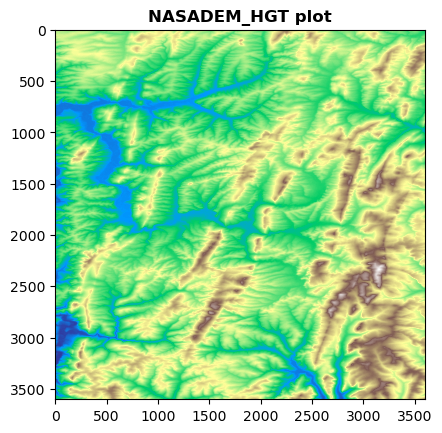

<Axes: title={'center': 'NASADEM_HGT plot'}>

In [23]:
from rasterio.plot import show
show(arr[0], cmap = 'terrain', title="NASADEM_HGT plot")

## Converting to Cloud-Optimized GeoTIFF (COG)

There are multiple ways to write a COG in Python. We are presenting the recommended approach based on `rio_cogeo.cog_translate` method using the Memoryfile. This approach is found to be efficient for writing big GeoTIFF files in cloud-optimized format along with copying the overviews and input dataset metadata. Also, we use the default "deflate" COG profile for writing the COGs. This can be defined to any of the existing [COG profiles](https://cogeotiff.github.io/rio-cogeo/profile/).

Note: The readers are recommended to follow the "The Ultimate data format ?" section of the article titled - [Do you really want people using your data ?](https://medium.com/@_VincentS_/do-you-really-want-people-using-your-data-ec94cd94dc3f). This section highlights how to follow these recommended practices in generating the COGs in Python.

In [35]:
# Defining the output COG filename
# path = data/NASADEM_HGT_n57e105_COG.tif
cog_filename = nasa_dem_filename.replace(".zip", "_COG.tif")

# Setting to default GTiff driver as we will be using `rio-cogeo.cog_translate()`
kwargs.update(driver="GTiff", predictor=2)

with MemoryFile() as memfile:
    # Opening an empty MemoryFile for in memory operation - faster
    with memfile.open(**kwargs) as mem:
        # Writing the array values to MemoryFile using the rasterio.io module
        # https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html
        mem.write(arr)

        dst_profile = cog_profiles.get("deflate")

        # Creating destination COG
        cog_translate(
            mem,
            cog_filename,
            dst_profile,
            use_cog_driver=True,
            in_memory=False
        )

/var/folders/h7/l61pvww15kz03l7fxjhts_wr0000gp/T/ipykernel_40851/4074752627.py:18: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
Reading input: <open DatasetWriter name='/vsimem/ae8e0898-8d08-4394-a034-817d492e0e04/ae8e0898-8d08-4394-a034-817d492e0e04.tif' mode='w+'>

Adding overviews...
Updating dataset tags...
Writing output to: data/NASADEM_HGT_n57e105_COG.tif


## Validating the Generated COG 

We can validate the generated COG using the `rio_cogeo.cog_validate`. The `cog_validate` method returns following outputs:
* `is_valid`: `bool` \
    True if 'src_path' is a valid COG.
* errors: `list` \
    List of validation errors if `is_valid` returns False.
* warnings: `list` \
    List of validation warnings if `is_valid` returns False.

In [25]:
cog_validate(cog_filename)

(True, [], [])

As we can see, the generated COG is a valid COG.

## Run validation tests

The `cog_validate` method runs on the COG file. Let's try to run a validation test on the arrays representing the COG and Non-COG file using Numpy's `assert_array_equal` [method](https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_array_equal.html).

In [26]:
# Reading the generated COG file
with rasterio.open(cog_filename) as src:
   arr_cog = src.read()

In [27]:
# Would not output anything if both the COG and non-COG files have equal values
numpy.testing.assert_array_equal(arr, arr_cog)

## Generating Overviews and Setting NoData Values

It is recommended to generate COGs with overviews and define NoData values in the COGs. The [Cloud Optimized Geotiff (COG) Overview Resampling](https://guide.cloudnativegeo.org/cloud-optimized-geotiffs/cogs-overview_resampling.html) notebook provides in-depth explanation for generating and visualizing overviews. Here, we will see how to -
1. Generate COGs with overviews in Python.
2. Set NoData values while generating COGs.

In [31]:
# Defining the output COG filename
# path = data/NASADEM_HGT_n57e105_COG.tif
cog_ovr_filename = nasa_dem_filename.replace(".zip", "_ovr_COG.tif")

# Setting to default GTiff driver as we will be using `rio-cogeo.cog_translate()`
kwargs.update(driver="GTiff", predictor=2)

# Setting the recommended blocksize to 512 per recommendations
kwargs.update({"blockxsize": "512", "blockysize": "512"})

with MemoryFile() as memfile:
    # Opening an empty MemoryFile for in memory operation - faster
    with memfile.open(**kwargs) as mem:
        # Writing the array values to MemoryFile using the rasterio.io module
        # https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html
        mem.write(arr)

        dst_profile = cog_profiles.get("deflate")

        # Creating destination COG
        cog_translate(
            mem,
            cog_ovr_filename,
            dst_profile,
            nodata=0,    #Set NoData value
            use_cog_driver=True,
            in_memory=False
        )

/var/folders/h7/l61pvww15kz03l7fxjhts_wr0000gp/T/ipykernel_40851/3894622244.py:21: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  cog_translate(
Reading input: <open DatasetWriter name='/vsimem/f8e96e37-cbaf-4db3-8873-e45475a36b8a/f8e96e37-cbaf-4db3-8873-e45475a36b8a.tif' mode='w+'>



Adding overviews...
Updating dataset tags...
Writing output to: data/NASADEM_HGT_n57e105_ovr_COG.tif
